**Queda por revisar**:

- Rellenar las series para hacer un análisis espectral amplio

# Importando las librerías

Las librerías usadas son las básicas para el análisis de datos temporales

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime,timedelta

In [ ]:
from ttide import t_tide

Se importa el script de ttide como una adaptación de la rutina de MATLAB desarrollada por Rich Pawlowicz

# Importando los datos de nivel medio del mar

Los datos fueron extraídos una estación del Sea Level Monitoring Center (un trabajo conjunto entre IOC y la UNESCO) que obedece al mareógrafo de Buenaventura.

In [3]:
df_nmm=pd.read_csv(r".\Dataset\rqh0085a.csv")
df_nmm

,Year,Month,Day,Hour,nmm
0,1953,5,12,0,660
1,1953,5,12,1,80
2,1953,5,12,2,30
3,1953,5,12,3,560
4,1953,5,12,4,1230
5,1953,5,12,5,1980
6,1953,5,12,6,2840
7,1953,5,12,7,3540
8,1953,5,12,8,3850
9,1953,5,12,9,3660


Se extraen los datos y se crea una serie con los datos de nivel del mar horarios

In [4]:
fechas=[datetime(df_nmm.Year.loc[i],df_nmm.Month.loc[i],df_nmm.Day.loc[i],df_nmm.Hour.loc[i]) for i in range(len(df_nmm))]
serie_nmm2=pd.Series(data=df_nmm.nmm.values/1000,index=fechas)

In [5]:
%matplotlib notebook
plt.figure()
# plt.plot(serie_nmm_fill)
plt.title("Serie de nivel del mar")
plt.plot(serie_nmm2)
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

<IPython.core.display.Javascript object>

C:\ProgramData\Anaconda3\lib\site-packages\pandas\plotting\_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


Text(0.5, 0, 'Tiempo [h]')

# Removiendo la tendencia

Las dos componentes de una serie temporal se pueden definir a través de la siguiente ecuación:

\begin{equation}
Serie\;temporal=Serie\;estacionaria+tendencia
\end{equation}

Dado que los valores de correlación lineales  se calculan para series estacionarias (definiendo una serie estacionaria cómo aquella que no tiene cambios en su media a lo largo del registro), es necesario eliminar la tendencia de la serie del mareografo.

In [6]:
# Es importante descontar la tendencia de la serie temporal de marea
ft=pd.DataFrame({"nmm":serie_nmm2.values,"año":[i for i in serie_nmm2.index.year]},index=serie_nmm2.index)
ft=ft.groupby(["año"]).mean()

In [7]:
desnivel=ft.iloc[-1]-ft.iloc[0]
tendencia=desnivel/(ft.index[-1]-ft.index[0])
# vector_resta2=np.ones((len(serie_nmm2),))*(float(tendencia)/8760)
serie_resta=pd.Series(data=[i*(float(tendencia)/8760) for i in range(len(serie_nmm2))],
                      index=serie_nmm2.index)

In [8]:
serie_nmm=serie_nmm2-serie_resta
plt.figure()
# plt.plot(serie_nmm_fill)
plt.plot(serie_nmm)
plt.title("Serie de nivel del mar sin tendencia")
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Tiempo [h]')

In [9]:
f=pd.DataFrame({"nmm":serie_nmm.values,"año":[i for i in serie_nmm.index.year]},index=serie_nmm.index)
f=f.groupby(["año"]).mean()

In [10]:
desnivel2=f.iloc[-1]-f.iloc[0]
tendencia2=desnivel2/(f.index[-1]-f.index[0])
# tendencia,tendencia2

El valor de la tendencia obtenido es 2.8 mm/año, cercano al reportado por diferentes autores, es un valor que se puede ver inducido por diferentes fenómenos físicos como el deshielo y la expansión térmica.

Después de removida la tendencia, es posible realizar las correlaciones planteadas posteriormente

In [11]:
plt.figure()
plt.subplot(211)
plt.title("Serie con tendencia")
plt.plot(ft,c="darkblue")
plt.plot([ft.index[0],ft.index[-1]],[ft.iloc[0],ft.iloc[-1]],ls='--',c="dodgerblue")
plt.ylim(1.95,2.3)
plt.ylabel("h [m]")
plt.xlabel("Tiempo [años]")

plt.subplot(212)
plt.title("Serie sin tendencia")
plt.plot(f,c="firebrick")
plt.plot([f.index[0],f.index[-1]],[f.iloc[0],f.iloc[-1]],ls='--',c="tomato")
plt.ylim(1.9,2.3)
plt.ylabel("h [m]")
plt.xlabel("Tiempo [años]")

plt.subplots_adjust(hspace=0.7)

<IPython.core.display.Javascript object>

# Completando la serie de marea 

Dado que la herramienta ttide.py determina las componentes armónicas de la serie de nivel medio del mar, para su buena estimación se requiere que el registro temporal no tenga vacíos, por lo tanto se procede a llenar la serie con ños datos del año 1984, dado que está completo y no implica la pérdida abrupta de la periodicidad de la serie, (esto es obviamente un ensayo).

In [12]:
date_fill=pd.date_range(serie_nmm.index[0],serie_nmm.index[-1],freq="H")
lista_fill=np.ones((len(date_fill),1))
for i in range(len(date_fill)):
    if date_fill[i] in serie_nmm.index:
        lista_fill[i]=serie_nmm[date_fill[i]]
    else:
        lista_fill[i]=serie_nmm[datetime(1984,date_fill[i].month,date_fill[i].day,date_fill[i].hour)]

In [13]:
serie_nmm_fill=pd.Series(data=lista_fill.ravel(),index=date_fill)

In [18]:
serie_nmm_fill

1953-05-12 00:00:00    0.660000
1953-05-12 01:00:00    0.080000
1953-05-12 02:00:00    0.029999
1953-05-12 03:00:00    0.559999
1953-05-12 04:00:00    1.229999
1953-05-12 05:00:00    1.979998
1953-05-12 06:00:00    2.839998
1953-05-12 07:00:00    3.539998
1953-05-12 08:00:00    3.849997
1953-05-12 09:00:00    3.659997
1953-05-12 10:00:00    2.909997
1953-05-12 11:00:00    1.879996
1953-05-12 12:00:00    0.939996
1953-05-12 13:00:00    0.319996
1953-05-12 14:00:00    0.207995
1953-05-12 15:00:00    0.609995
1953-05-12 16:00:00    1.279995
1953-05-12 17:00:00    2.090994
1953-05-12 18:00:00    2.931994
1953-05-12 19:00:00    3.634994
1953-05-12 20:00:00    4.039993
1953-05-12 21:00:00    4.139993
1953-05-12 22:00:00    3.579993
1953-05-12 23:00:00    2.599992
1953-05-13 00:00:00    1.469992
1953-05-13 01:00:00    0.489992
1953-05-13 02:00:00   -0.180009
1953-05-13 03:00:00   -0.110009
1953-05-13 04:00:00    0.459991
1953-05-13 05:00:00    1.179990
                         ...   
2014-12-

In [14]:
plt.figure()
plt.plot(serie_nmm_fill)
plt.title("Serie de nivel del mar llenada")
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

<IPython.core.display.Javascript object>

Text(0.5, 0, 'Tiempo [h]')

# Series de marea real y astronómica

Dado que existe un rango de fechas dónde no hay vacíos (1980-1986), se usa este para la estimación de los componentes armónicos de la marea astronómica

In [130]:
fecha_inicio=datetime(1978,1,1)
fecha_fin=datetime(1984,1,1)

In [131]:
def preparing_ttide(serie,inicio,fin):
    serie_anm=serie-np.mean(serie)
    slice_serie_anm=serie_anm[inicio:fin]
    return slice_serie_anm

serie_real=preparing_ttide(serie_nmm_fill,fecha_inicio,fecha_fin)

def astronomica(serie_real):
    ttide=t_tide(serie_real,dt=1)
    ttide_out=ttide
    datos_astro=ttide_out["xout"].ravel()
    serie_astro=pd.Series(data=datos_astro,index=serie_real.index)
    return serie_astro

serie_astro=astronomica(serie_real)

def plotting(serie_real,serie_astro):
    fig,ax=plt.subplots(1,1)
    ax.plot(serie_real,label="Marea total")
    ax.plot(serie_astro,label="Marea astronómica")
    ax.legend()
    plt.title("Series de nivel del mar")
    ax.set_ylabel("h [m]")
    ax.set_xlabel("Tiempo [h]")
    plt.savefig(".\Plots\Marea_real-Marea_astronomica.png",dpi=400,box_inches="tight")
    return fig

-----------------------------------
nobs = 52585 
ngood = 52585 
record length (days) = 2191.04
rayleigh criterion = 1.0

Phases at central time
x0= 0.048  xtrend= 0
var(data)= 1.32    var(prediction)= 1.21    var(residual)= 0.11
var(prediction)/var(data) (%) = 91.6

        tidal amplitude and phase with 95 % CI estimates
 tide      freq        amp      amp_err   pha      pha_err    snr
* SA    0.0001141     0.0622     0.011    251.81      9.26        33
* SSA   0.0002282     0.0566     0.011    290.74     10.80        28
  MSM   0.0013098     0.0131     0.010    306.73     44.99       1.8
* MM    0.0015122     0.0205     0.011    215.24     29.95       3.8
* MSF   0.0028219     0.0250     0.010    178.19     23.88       6.4
  MF    0.0030501     0.0112     0.010    347.54     53.27       1.3
  ALP1  0.0343966     0.0013     0.001    213.89     59.72      0.89
* 2Q1   0.0357064     0.0030     0.001    202.54     21.87       4.9
* SIG1  0.0359087     0.0022     0.001     24.83     33.7

<IPython.core.display.Javascript object>


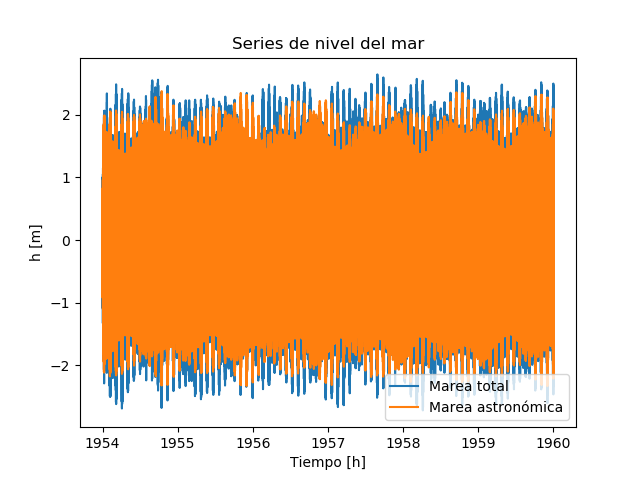

In [123]:
plot_mareas=plotting(serie_real,serie_astro)

# Envolvente de máximos y mínimos (inclusive suavizadas)

Al examinar la marea astronómica vs la marea real, se obtiene que existen unos desfases que implican valores máximos de marea residual errados, es por esto que por practicidad, se decide extraer una envolvente de máximos y mínimos diaria de ambas series y posteriormente restarlas, aunque se pasa de una resolución horaria a diaria, se eliminan los datos erróneos en la primera resolución.

In [23]:
def smooth(y,box_pts):
    box=np.ones(box_pts)/box_pts
    y_smooth=np.convolve(y,box,mode="same")
    return y_smooth

In [69]:
def maximos(serie_real,serie_astro,inicio):
    maximos_real,fechas_real=[],[]
    maximos_astro,fechas_astro=[],[]
    for k in range(int(len(serie_real)/24)):

        #Ventana de marea real
        window_real=serie_real[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))-timedelta(hours=1)]
        max_window_real=np.max(window_real)

        #Ventana de marea astronómica
        window_astro=serie_astro[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))-timedelta(hours=1)]
        max_window_astro=np.max(window_astro)

        if max_window_real>0 and max_window_astro>0:
            maximos_astro.append(max_window_astro)
            fechas_astro.append(window_astro.idxmax()-timedelta(hours=window_astro.idxmax().hour))    
            maximos_real.append(max_window_real)
            fechas_real.append(window_real.idxmax()-timedelta(hours=window_real.idxmax().hour))

    #Series de máximos
    serie_maximos_real=pd.Series(data=maximos_real,index=fechas_real)
    serie_maximos_astro=pd.Series(data=maximos_astro,index=fechas_astro)
    return serie_maximos_real,serie_maximos_astro

serie_max_real=maximos(serie_real,serie_astro,fecha_inicio)[0]
serie_max_astro=maximos(serie_real,serie_astro,fecha_inicio)[1]

def minimos(serie_real,serie_astro,inicio):
    minimos_real,fechas_real_min=[],[]
    minimos_astro,fechas_astro_min=[],[]
    for k in range(int(len(serie_real)/24)):

        #Ventana de marea real
        window_real=serie_real[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))-timedelta(hours=1)]
        min_window_real=np.min(window_real)

        #Ventana de marea astronómica
        window_astro=serie_astro[inicio+timedelta(days=int(k)):inicio+timedelta(days=int(k+1))-timedelta(hours=1)]
        min_window_astro=np.min(window_astro)

        if min_window_real<0 and min_window_astro<0:
            minimos_astro.append(min_window_astro)
            fechas_astro_min.append(window_astro.idxmin()-timedelta(hours=window_astro.idxmin().hour))    
            minimos_real.append(min_window_real)
            fechas_real_min.append(window_real.idxmin()-timedelta(hours=window_real.idxmin().hour))

    #Series de minimos
    serie_minimos_real=pd.Series(data=minimos_real,index=fechas_real_min)
    serie_minimos_astro=pd.Series(data=minimos_astro,index=fechas_astro_min)
    return serie_minimos_real,serie_minimos_astro

serie_min_real=minimos(serie_real,serie_astro,fecha_inicio)[0]
serie_min_astro=minimos(serie_real,serie_astro,fecha_inicio)[1]

In [70]:
def plotting_max_min(serie_max_real,serie_max_astro,serie_min_real,serie_min_astro):
    fig,ax=plt.subplots(1,1)
    ax.set_title("Máximos diarios de marea")
    ax.plot(serie_max_real,label="Marea total")
    ax.plot(serie_max_astro,label="Marea astronómica")
    ax.legend()
    ax.set_ylabel("h [m]")
    ax.set_xlabel("Tiempo [h]")
    plt.savefig(".\Plots\Envolvente de maximos.png",dpi=400,box_inches="tight")

    fig2,ax2=plt.subplots(1,1)
    ax2.set_title("Mínimos diarios de marea")
    ax2.plot(serie_min_real,label="Marea total")
    ax2.plot(serie_min_astro,label="Marea astronómica")
    ax2.legend()
    ax.set_ylabel("h [m]")
    ax.set_xlabel("Tiempo [h]")
    plt.savefig(".\Plots\Envolvente de minimos.png",dpi=400,box_inches="tight")
    return fig,fig2

<IPython.core.display.Javascript object>


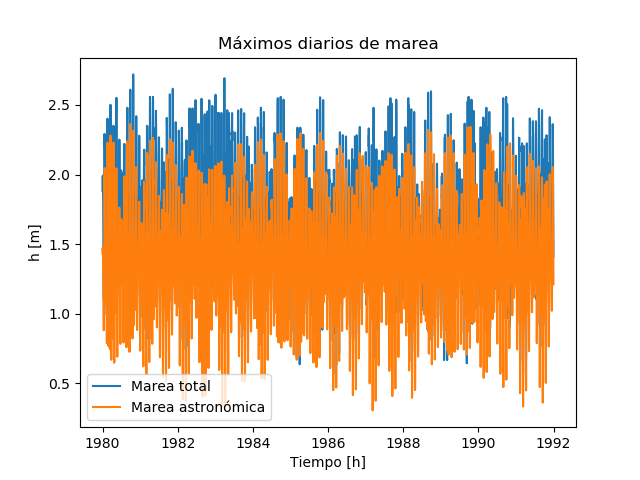

<IPython.core.display.Javascript object>


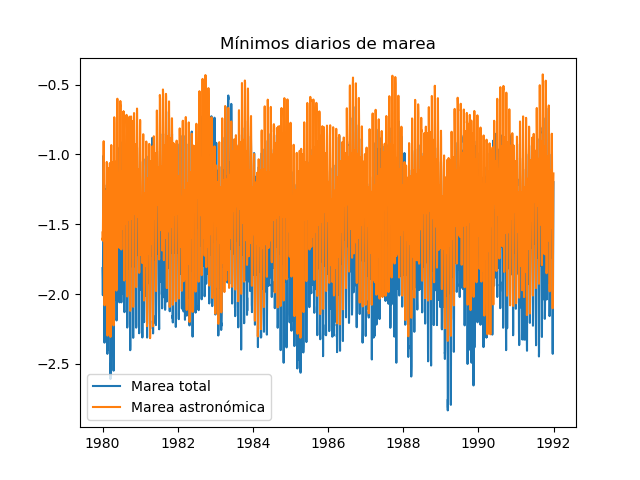

In [71]:
plot_mareas=plotting_max_min(serie_max_real,serie_max_astro,serie_min_real,serie_min_astro)

In [72]:
def smoothed(serie_max_real,serie_max_astro,serie_min_real,serie_min_astro):
    serie_dif_maximos=serie_max_real-serie_max_astro
    dif_maximos_smoothed=smooth(serie_dif_maximos,30)
    serie_dif_minimos=serie_min_real-serie_min_astro
    dif_minimos_smoothed=smooth(serie_dif_minimos,30)
    serie_maximos_smoothed=pd.Series(data=dif_maximos_smoothed,index=serie_dif_maximos.index)
    serie_minimos_smoothed=pd.Series(data=dif_minimos_smoothed,index=serie_dif_minimos.index)
    return serie_dif_maximos,serie_dif_minimos,serie_maximos_smoothed,serie_minimos_smoothed

serie_dif_maximos,serie_dif_minimos,serie_maximos_smoothed,serie_minimos_smoothed=smoothed(serie_max_real,serie_max_astro,serie_min_real,serie_min_astro)

In [28]:
def plotting_smoothed(serie1,serie2):
    fig,ax=plt.subplots(1,1)
    ax.plot(serie1)
    ax.set_title("Envolvente de maximos suavizada")
    ax.set_ylabel("h [m]")
    ax.set_xlabel("Tiempo [h]")
    plt.savefig(".\Plots\Envolvente de maximos_suavizada.png",dpi=400,box_inches="tight")

    fig2,ax2=plt.subplots(1,1)
    ax2.plot(serie2)
    ax2.set_title("Envolvente de minimos suavizada")
    ax2.set_ylabel("h [m]")
    ax2.set_xlabel("Tiempo [h]")
    plt.savefig(".\Plots\Envolvente de minimos_suavizada.png",dpi=400,box_inches="tight")
    return fig,fig2

<IPython.core.display.Javascript object>


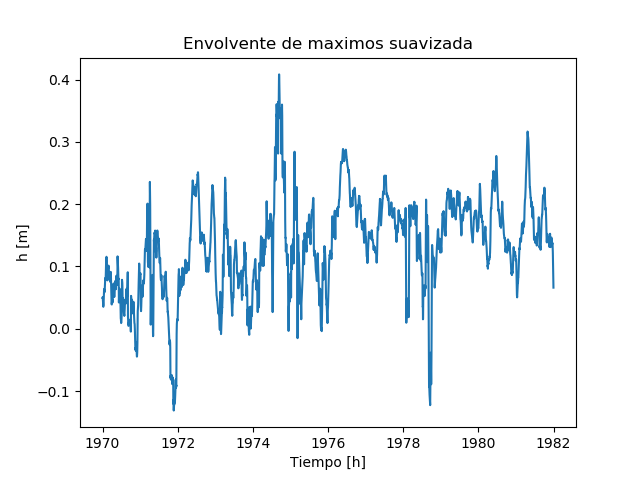

<IPython.core.display.Javascript object>


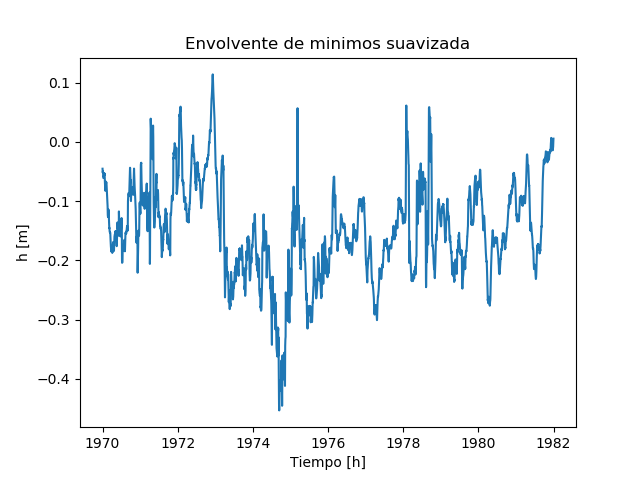

In [29]:
plot_smooth_max,plot_smooth_min=plotting_smoothed(serie_maximos_smoothed,serie_minimos_smoothed)

## Verificación del suavizado

Al graficar la envolvente de máximos y mínimos hay mucha variación de un dato a otro, por lo tanto se suaviza la serie en ventanas de 1 mes

In [ ]:
plt.figure()
plt.title("Serie de M")
plt.plot(serie_dif_maximos,c="orange",alpha=0.5)
plt.plot(serie_maximos_smoothed,c="k")
plt.ylabel("h [m]")
plt.xlabel("Tiempo [h]")

# Análisis espectral
Dado que Fourier tiene problemas con los datos faltantes, se reliza primero el análisis espectral de forma preliminar para el rango de fechas (1980-1986), con el objetivo de conocer los máximos períodos en una escala menor a la diaria.

## Con los 6 años de datos completos

In [ ]:
def T_fourier(serie):
    fourier=np.fft.fft(serie)
    freq= np.fft.fftfreq(len(serie)) 
    pot = np.abs(fourier*1./len(fourier))**2
    periodos = 1/freq
    freq_pos=np.where(freq>=0)[0]
    
    return fourier,freq_pos,pot,periodos,freq

In [ ]:
# nmm_fourier_anm=serie_maximos_smoothed.values-np.mean(serie_real.values)
nmm_fourier,nmm_freq_pos,nmm_potencias,nmm_periodos,nmm_freq,=T_fourier(serie_real.values)

Las lines punteadas están en 6, 12 y 24 horas.

In [ ]:
plt.figure(figsize=(8,4))
plt.suptitle("Espectro de potencias de Fourier")
plt.subplot(121)
plt.plot(nmm_periodos[nmm_freq_pos],nmm_potencias[nmm_freq_pos],'-o',c="tomato")
# plt.xscale("log")
plt.axvline(x=6,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=12,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=24,ymin=0,ymax=1,ls="--",c='k')
plt.xlabel("Período [horas]")
plt.ylabel("Potencia [$mm^{2}$]")
plt.savefig(".\Plots\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

plt.subplot(122)
plt.plot(nmm_periodos[nmm_freq_pos],nmm_potencias[nmm_freq_pos],'-o',c="tomato")
# plt.xscale("log")
plt.axvline(x=6,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.axvline(x=12,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.axvline(x=24,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.xlabel("Período [horas]")
plt.ylabel("Potencia [$mm^{2}$]")
plt.xlim(0,30)
plt.ylim(0,0.1)
plt.savefig(".\Plots\Espectro de potencias.jpg",dpi=800,box_inches="tight",pad_inches=0)

plt.subplots_adjust(wspace=0.3)

## Con la serie completa
Los vacios de la serie se llenaron con la media de un año cuañquiera, sin embargo hay que reviar varias cosas, dentro de esas el hacerlo con la serie original o meteorológica.

In [ ]:
nmm_fill_fourier,nmm_fill_freq_pos,nmm_fill_potencias,nmm_fill_periodos,nmm_fill_freq,=T_fourier(serie_nmm_fill.values-np.mean(serie_nmm_fill.values))

In [ ]:
plt.figure(figsize=(8,4))
plt.suptitle("Espectro de potencias de Fourier serie completa")
plt.subplot(121)
plt.plot(nmm_fill_periodos[nmm_fill_freq_pos],nmm_fill_potencias[nmm_fill_freq_pos],'-o',c="tomato")
# plt.xscale("log")
plt.xlabel("Período [horas]")
plt.ylabel("Potencia [$mm^{2}$]")
plt.axvline(x=6,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=12,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=24,ymin=0,ymax=1,ls="--",c='k')

plt.subplot(122)
plt.plot(nmm_fill_periodos[nmm_fill_freq_pos],nmm_fill_potencias[nmm_fill_freq_pos],'-o',c="tomato")
# plt.xscale("log")
plt.axvline(x=6,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=12,ymin=0,ymax=1,ls="--",c='k')
plt.axvline(x=24,ymin=0,ymax=1,ls="--",c='k')
plt.xlabel("Período [horas]")
plt.ylabel("Potencia [$mm^{2}$]")
plt.xlim(0,30)
plt.ylim(0,0.002)

plt.savefig(".\Plots\Espectro de potencias_fill.jpg",dpi=800,box_inches="tight",pad_inches=0)
plt.subplots_adjust(wspace=0.4)


## Filtrando la serie de datos en los períodos de interés

Removiendo el ciclo diario de la marea (mayor a las 3000 horas), dado que determina gran parte de la potencia de la serie, se obtiene un serie de fourier donde aparece el ciclo semianual y anual, también aparecen frecuencias superiores a las anuales que deben revisarse a detalle.

In [ ]:
nmm_freq_fil=np.copy(nmm_fill_fourier)
nmm_freq_fil[np.where(np.abs(1/nmm_fill_freq)<3000)]=0

nmm_pot_fil=np.abs(nmm_freq_fil*1/len(nmm_freq_fil))**2
Serie_fil= np.fft.ifft(nmm_freq_fil)

In [ ]:
plt.figure(figsize=(10,4))
plt.subplot(121)
plt.plot(nmm_fill_periodos[nmm_fill_freq_pos],nmm_pot_fil[nmm_fill_freq_pos],'-o',c="salmon")
# plt.xscale("log")
plt.xlabel("Período [horas]")
plt.ylabel("Potencia")
plt.axvline(x=8760/2,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.axvline(x=8760,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)

plt.subplot(122)
plt.plot(nmm_fill_periodos[nmm_fill_freq_pos],nmm_pot_fil[nmm_fill_freq_pos],'-o',c="salmon")
# plt.xscale("log")
plt.xlabel("Período [horas]")
plt.ylabel("Potencia")
plt.axvline(x=8760/2,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.axvline(x=8760,ymin=0,ymax=1,ls="--",c='k',alpha=0.5)
plt.ylim(0,0.00030)
plt.xlim(0,35000)

plt.subplots_adjust(wspace=0.3)

plt.savefig(".\Plots\Banda espectral interes.jpg",dpi=800,box_inches="tight",pad_inches=0)

# Índice ONI

Paralelo al procedimiento anterior, se descargan las serie temporal del índice oni, desde el sitio web <a href="https://origin.cpc.ncep.noaa.gov/products/analysis_monitoring/ensostuff/ONI_v5.php">ONI NOAA</a>, Este índice es la anomalía de la TSM de la región El Niño 3.4

In [30]:
dataset_oni=pd.read_excel(r".\Dataset\oni index.xlsx").set_index("Year")

In [64]:
def serie_oni(dataset_oni):
    data=dataset_oni.values.ravel()
    fechas=pd.date_range("1950-01-01","2019-01-01",freq="M")
    date=[i-timedelta(days=15) for i in fechas]
    serie_oni_d=pd.Series(data=data,index=date)[fecha_inicio:fecha_fin]
    return serie_oni_d

Serie_oni=serie_oni(dataset_oni)

## Identificación de eventos ENSO según el índice ONI

Cuando alrededor de un mes existen 5 meses consecutivos mayores a 0.5 o menores a -0.5, se puede  hablar de un evento cálido/frío, con esta serie se determinan los diferentes eventos ENSO sucedidos entre 1980-1986.

In [65]:
def looking_for_events(Serie_oni):
    loc_niña=[] #Revisar siempre estas posiciones
    loc_niño=[0]
    for i in range (4,int(len(Serie_oni)-4)):
        k=0
        d=0
        z=0
        while k<5:
            a=i+k-4
            b=i+k+1
            window=np.around(np.asarray((Serie_oni.values[a:b])),1)
            test_niño=window>=0.5
            test_niña=window<=-0.5
            if test_niño.all()==True:
                d=d+1
            if test_niña.all()==True:
                z=z+1
            k=k+1
        if d>=1:
            loc_niño.append(i)
        if z>=1:
            loc_niña.append(i)
    return loc_niña,loc_niño
                    
locs_niña,locs_niño=looking_for_events(Serie_oni)     
                                        
def events(loc_niño,loc_niña):
    fines_niña=np.where(np.diff(loc_niña)!=1)[0].tolist()+[len(loc_niña)-1]
    fines_niño=np.where(np.diff(loc_niño)!=1)[0].tolist()+[len(loc_niño)-1]
    inicios_niña=[0]+[i+1 for i in fines_niña][:-1]
    inicios_niño=[0]+[i+1 for i in fines_niño][:-1]
    return inicios_niño,fines_niño,inicios_niña,fines_niña

inicio_niño,fin_niño,inicio_niña,fin_niña=events(locs_niño,locs_niña)

def plotting_events(Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
    fig,ax=plt.subplots(1,1)
    ax.plot(Serie_oni,'-o',c='k')
    ax.set_title("Eventos ENSO")
    ax.set_yticks(np.arange(-3,3,0.5))
    ax.grid()
    for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
    for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
    plt.savefig(".\Plots\Eventos_ENSO.png",dpi=400,box_inches="tight")
    return fig

<IPython.core.display.Javascript object>


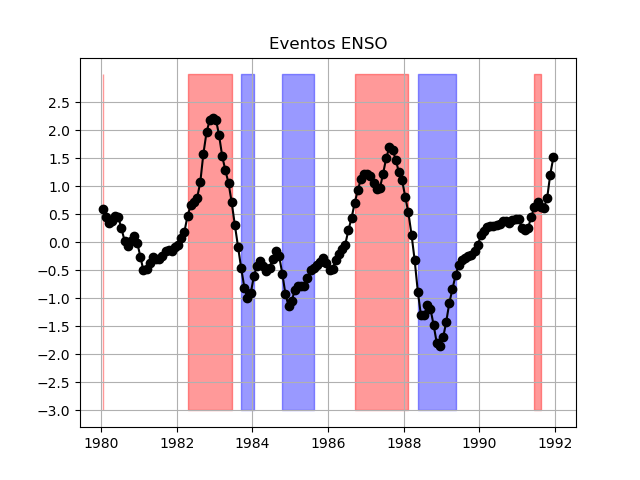

In [66]:
plots_ENSO=plotting_events(Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña)

Los eventos captados según la serie de oni, están respaldados por la página de descarga y por la página https://ggweather.com/enso/oni.htm, dónde se destaca el registro del niño de 1982-1983 de intensidad muy fuerte y la niña débil de 1985

## Gráfica de nmm y su relación con ENSO

Finalmente, al superponer los eventos del ENSO con la envolvente de nivel medio del mar suavizada,(en representación de la marea residual), puede visualizarse de forma inicial, que en los momentos en que la serie de nmm presentó un mayor aumento también ocurrió un fase calida del ENSO (el niño) y cuando presente un mayor decremento ocurrió una fase fría del ENSO (la niña)

In [73]:
def converge(serie_oni,serie_original,serie_smoothed,Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
        fig,ax=plt.subplots(1,1)
#         ax.plot(serie_oni,c='red',alpha=0.5)
        ax.plot(serie_original,c='orange',alpha=0.5)
        ax.set_title("Serie de nmm vs Eventos ENSO [ONI]")
        ax.plot(serie_smoothed,c='k')
        ax.set_yticks(np.arange(-3,3,0.5))
        ax.set_ylim(-0.5,0.5)
        ax.grid()
        ax.set_ylabel("h [m]")
        ax.set_xlabel("Tiempo [h]")
        for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
            ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
        for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
            ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
        plt.savefig(".\Plots\All.png",dpi=400,box_inches="tight")
        return fig

<IPython.core.display.Javascript object>


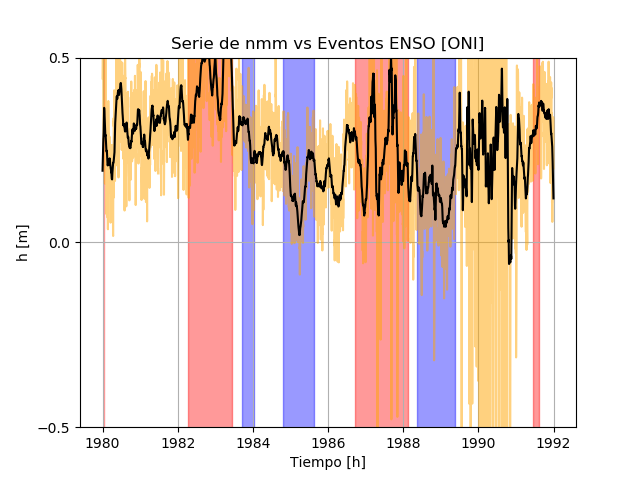

In [74]:
plot_final=converge(Serie_oni,serie_dif_maximos,serie_maximos_smoothed,Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña)

## Correlación lineal nmm-ONI

Lo anterior da una idea de la correlación que puedan presentar ambas series, por lo tanto, se decide comparar linealmente los datos de mmm y del ONI, se resalta que dado que están a diferentes resoluciones, la serie de mayor resolución se reduce a la resolución de la serie de menor, es decir, la serie de nmm se lleva a resolución mensual, y así se compara en un scatterplot con el ONI.

In [39]:
df_maximos=pd.DataFrame(data={'maximos':serie_maximos_smoothed.values,'meses':[i.month for i in serie_maximos_smoothed.index],
                              'años':[i.year for i in serie_maximos_smoothed.index]},index=serie_maximos_smoothed.index)

In [40]:
medios_mensuales=df_maximos.groupby(["años","meses"]).mean().values.ravel()
Serie_medios_mensuales=pd.Series(data=medios_mensuales,index=Serie_oni.index)

<IPython.core.display.Javascript object>


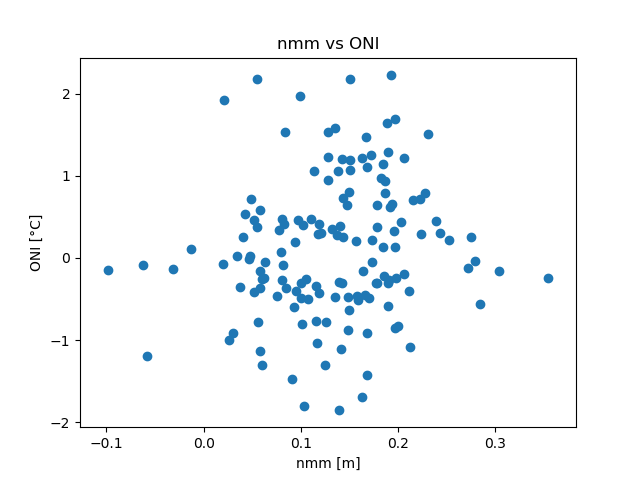

Text(0, 0.5, 'ONI [°C]')

In [75]:
plt.figure()
plt.title("nmm vs ONI")
plt.scatter(Serie_medios_mensuales.values,Serie_oni.values)
plt.xlabel('nmm [m]')
plt.ylabel('ONI [°C]')

In [42]:
from scipy.stats import pearsonr,spearmanr

ps_oni=pearsonr(Serie_medios_mensuales.values,Serie_oni.values)[0]
sp_oni=spearmanr(Serie_medios_mensuales.values,Serie_oni.values).correlation

Los valores obtenidos para la correlación de Pearaon y Spearman fueron:

- Spearman: {{round(sp_oni,2)}}
- Pearson: {{round(ps_oni,2)}}

## Correlograma nmm-ONI

Finalmente, se grafican los correlogramas con diferentes rezagos y puede identificarse que existen valores de correlaciones de Pearson importantes para el rezago mensual +1, es decir, el mayor efecto del evento cálido o frío del ENSO sobre el nivel medio del mar ocurre 1 mes después (lo cual puede ser coherente con el arribo de una onda kelvin desde el pacífico ecuatiorial occidental hasta el pacifico ecuatorial oriental)

In [43]:
def correlation (serie2,b):
    
    corr=[pearsonr(Serie_medios_mensuales[:-i],serie2[i:])[0] for i in range(1,13)[::-1]]
    corr=corr+[pearsonr(Serie_medios_mensuales,serie2)[0]]+[pearsonr(Serie_medios_mensuales[i:],serie2[:-i])[0]
        for i in range(1,13)]
    
    corr2=[spearmanr(Serie_medios_mensuales[:-i],serie2[i:])[0] for i in range(1,13)[::-1]]
    corr2=corr2+[spearmanr(Serie_medios_mensuales,serie2)[0]]+[spearmanr(Serie_medios_mensuales[i:],serie2[:-i])[0] for i in range(1,13)]
    
    
    fig=plt.figure(figsize=(8,4))
    ax=fig.add_subplot(211)
    ax.bar(range(-12,13),corr,color='firebrick')
    ax.set_title('Correlación de Pearson nmm-'+b)
#     ax.set_ylabel(u'Pearson')
    ax.set_xlabel('Rezago')
    ax.set_xticks(range(-12,13))
    ax.grid(linestyle='--',lw=2,alpha=.2)
    
    ax2=fig.add_subplot(212)
    ax2.bar(range(-12,13),corr2,color='darkcyan')
    ax2.set_title('Correlación de Spearman nmm-'+b)
#     ax2.set_ylabel(u'Spearman')
    ax2.set_xlabel('Rezago')
    ax2.set_xticks(range(-12,13))
    ax2.grid(linestyle='--',lw=2,alpha=.2)
    
    plt.subplots_adjust(hspace=0.8)
    plt.savefig(".\Plots\Rezagos con "+b)
#    

    return ax,ax2

<IPython.core.display.Javascript object>


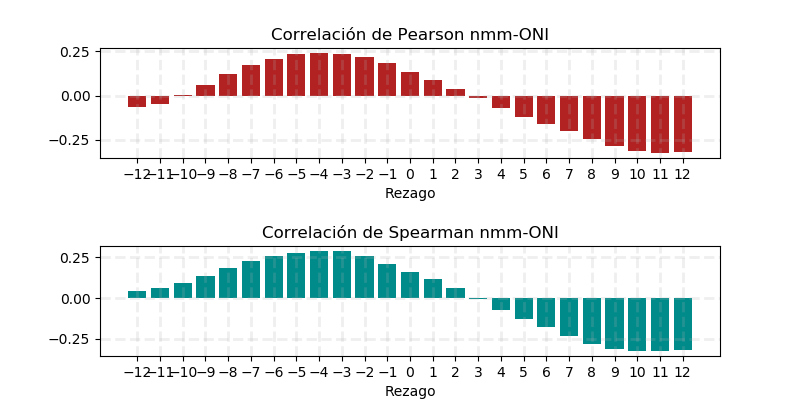

(<matplotlib.axes._subplots.AxesSubplot at 0x2183a413e80>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2183b359550>)

In [76]:
correlation(Serie_oni.values,"ONI")

# Índice MEI

De forma similar a la serie del ONI, se calcula la serie del MEI, el índice multivariado del ENSO que toma en cuenta las variables de presión en superficie, TSM, OLR, vientos zonales, vientos meridionales y demás. Se realiza el mismo procedimiento descrito anteriormente para el ONI. Página de descarga:https://www.esrl.noaa.gov/psd/enso/mei/

## Identificación de eventos ENSO con MEI

Cuando un mes es mayor a 0.5 o menor a -0.5, se puede  hablar de un evento cálido/frío,  con  esta serie se determinan los diferentes eventos ENSO sucedidos entre 1980-1986

Los eventos captados según la serie de MEI, están respaldados por la página de descarga y por la página https://ggweather.com/enso/oni.htm, dónde se destaca el registro del niño de 1982-1983 de intensidad muy fuerte y la niña débil de 1985

In [79]:
dataset_mei=pd.read_excel(r".\Dataset\mei index.xlsx").set_index("Year")

In [80]:
def serie_mei(dataset_mei):
    data=dataset_mei.values.ravel()
    fechas=pd.date_range("1979-01-01","2019-01-01",freq="M")
    date=[i-timedelta(days=15) for i in fechas]
    serie_mei_d=pd.Series(data=data,index=date)[fecha_inicio:fecha_fin]
    return serie_mei_d

Serie_mei=serie_mei(dataset_mei)


In [81]:
def looking_for_eventsMEI(Serie_mei):
    locs_niña_mei=[]
    locs_niño_mei=[]
    for i in range (0,len(Serie_mei)):
        if round(Serie_mei[i],2)>=0.5:
            locs_niño_mei.append(i)
        elif round(Serie_mei[i],2)<=-0.5:
            locs_niña_mei.append(i)
    return locs_niño_mei,locs_niña_mei

In [82]:
def events_MEI(loc_niño,loc_niña):
    fines_niña=np.where(np.diff(loc_niña)!=1)[0].tolist()+[len(loc_niña)-1]
    fines_niño=np.where(np.diff(loc_niño)!=1)[0].tolist()+[len(loc_niño)-1]
    inicios_niña=[0]+[i+1 for i in fines_niña][:-1]
    inicios_niño=[0]+[i+1 for i in fines_niño][:-1]
    return inicios_niño,fines_niño,inicios_niña,fines_niña

In [83]:
locs_niño2,locs_niña2=looking_for_eventsMEI(Serie_mei)     

inicios_niño2,fines_niño2,inicios_niña2,fines_niña2=events_MEI(locs_niño2,locs_niña2)

In [84]:
def plotting_events_mei(Serie_mei,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
    fig,ax=plt.subplots(1,1)
    ax.plot(Serie_mei,'-o',c='k')
    ax.set_title("Eventos ENSO [MEI]")
    ax.set_yticks(np.arange(-3,3,0.5))
    ax.grid()
    ax.set_ylabel("MEI")
    ax.set_xlabel("Tiempo [meses]")
#     for i in range(0,len(Serie_mei)): #Niño y después niña
#         try:
#             ax.fill_betweenx([-3,3],Serie_mei.index[locs_niño[i]],Serie_mei.index[locs_niño[i]],color="r",alpha=0.4)
#         except:
#             d=0
#     for j in range(0,len(Serie_mei)): #Niño y después niña
#         try:
#             ax.fill_betweenx([-3,3],Serie_mei.index[locs_niña[j]],Serie_mei.ndex[locs_niña[j]],color="b",alpha=0.4) 
#         except:
#             d=0
    for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
    for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
        ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
    plt.savefig(".\Plots\Eventos_ENSO[MEI].png",dpi=400,box_inches="tight")
    return fig

<IPython.core.display.Javascript object>


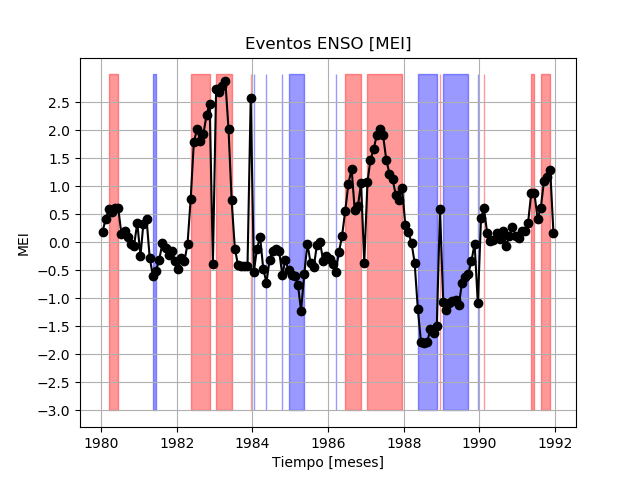

In [85]:
plots_ENSO_MEI=plotting_events_mei(Serie_mei,inicios_niño2,fines_niño2,locs_niño2,inicios_niña2,fines_niña2,locs_niña2)

## Gráfica de nmm y su relación con ENSO

Igualmente al usar la serie suavizada con los eventos según el MEI, se visualiza una correlación positiva entre las dos variables, aunque esto se amplía al detalle con un scatterplot.

In [86]:
def converge_mei(serie_original,serie_smoothed,Serie_oni,inicio_niño,fin_niño,locs_niño,inicio_niña,fin_niña,locs_niña):
        fig,ax=plt.subplots(1,1)
#         ax.plot(serie_oni,c='red',alpha=0.5)
        ax.plot(serie_original,c='orange',alpha=0.5)
        ax.set_title("Serie de nmm vs Eventos ENSO [MEI]")
        ax.plot(serie_smoothed,c='k')
        ax.set_yticks(np.arange(-3,3,0.5))
        ax.set_ylim(-0.5,0.5)
        ax.grid()
        ax.set_ylabel("h [m]")
        ax.set_xlabel("Tiempo [h]")
        for i,k in zip(inicio_niño,fin_niño): #Niño y después niña
            ax.fill_betweenx([-3,3],Serie_oni.index[locs_niño[i]],Serie_oni.index[locs_niño[k]],color="r",alpha=0.4)
        for j,m in zip(inicio_niña,fin_niña): #Niño y después niña
            ax.fill_betweenx([-3,3],Serie_oni.index[locs_niña[j]],Serie_oni.index[locs_niña[m]],color="b",alpha=0.4) 
        plt.savefig(".\Plots\All_MEI.png",dpi=400,box_inches="tight")
        return fig

<IPython.core.display.Javascript object>


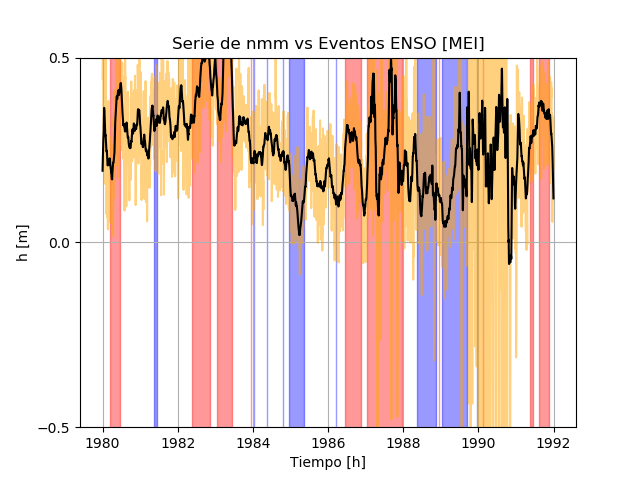

In [87]:
plot_final_MEI=converge_mei(serie_dif_maximos,serie_maximos_smoothed,Serie_mei,inicios_niño2,fines_niño2,
                        locs_niño2,inicios_niña2,fines_niña2,locs_niña2)

## Correlación lineal nmm-MEI

<IPython.core.display.Javascript object>


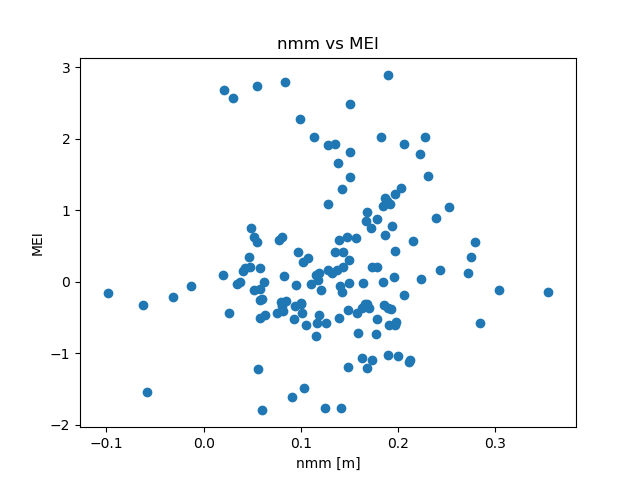

Text(0, 0.5, 'MEI')

In [88]:
plt.figure()
plt.scatter(Serie_medios_mensuales.values,Serie_mei.values)
plt.title("nmm vs MEI")
plt.xlabel('nmm [m]')
plt.ylabel('MEI')

In [89]:
ps_mei=pearsonr(Serie_medios_mensuales.values,Serie_mei.values)[0]
sp_mei=spearmanr(Serie_medios_mensuales.values,Serie_mei.values).correlation

Los coeficientes de correlación nmm-MEI son:


- Spearman: {{round(sp_mei,2)}}
- Pearson: {{round(ps_mei,2)}}

## Correlograma nmm-MEI

<IPython.core.display.Javascript object>


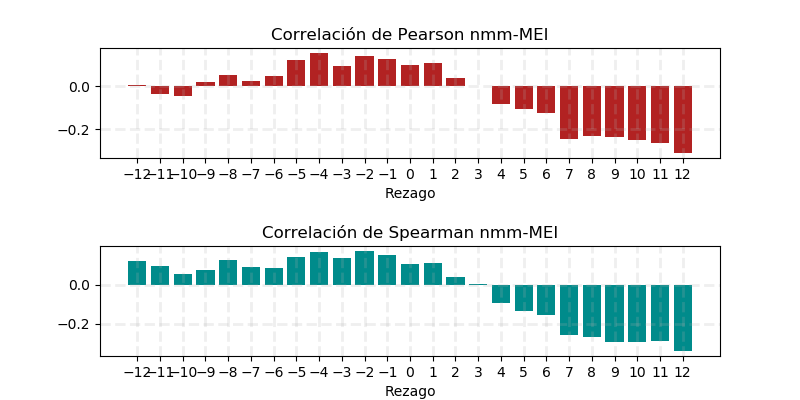

(<matplotlib.axes._subplots.AxesSubplot at 0x21833a05eb8>,
 <matplotlib.axes._subplots.AxesSubplot at 0x2183400bb38>)

In [90]:
correlation(Serie_mei.values,"MEI")

El correlograma nmm vs MEI, indica un máximo valor de correlación en el rezago +2, conclusión similar a la del ONI.


# Hasta ahora

- Los valores de Pearson son muy susceptibles a los valores extremos, por lo tanto, siempre es necesario acompañar estos valores con los coeficientes de Spearman, los cuales al ser medidas no paramétricas, no se ven alterados por eventos extremos.

- Indagarse por el comportamiento del correlograma de Spearman entre nmm-ONI

- Aunque los valores de correlación den positivos en inclusive mayores a 0.7 (relación lineal estrecha) no implican causalidad de una variable sobre la otra. La causalidad la determina el entendimiento profundo del fenómeno físico estudiado

- Era de esperarse que el mayor aporte a la potencia de la serie de Fourier fuese en la escala diurna y anual, sin embargo, existe una escala de tiempo mayor a la anual que debe revisarse a profundidad.

In [ ]:
a=np.ones((len(Serie_on)))

In [3]:
a=["0030","0130","0200","0230","0300"]
c=datetime(1900,1,1,0,30,0)

In [10]:
d=str(c.hour)+str(c.minute)

In [16]:
for i in a:
    if i[1:] ==d or i[:]==d:
        print("está en la lista")

está en la lista
